In [12]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib
# matplotlib.use('Qt5Agg',force=True)
# matplotlib.use("TKAgg",force=True)
# matplotlib.use("widget",force=True)
import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import pickle as pkl
import xarray as xr

from boutdata.restart import addvar
import glob
import shutil

import scipy

sys.path.append(r"/home/mike/work/sdtools")

from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.neutral_transport import NeutralTransport
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from hermes3.balance1d import *

# from remkit.load import load_remkit
# from code_comparison.code_comparison import *

from cycler import cycler
mpl.rcParams["axes.prop_cycle"] = cycler("color", ["teal", "darkorange", "firebrick", "limegreen", "darkorchid", "deeppink", 
                                                   "#1E90FF", "forestgreen", "#4169e1", "darkgoldenrod", "#9370db", "crimson", "#2f4f4f" ])

sys.path.append(r"/home/mike/work/ReMKiT1D_H3/scripts")
from comp_utils import H3CompFromJSON,H3nTCompPlot,H3qGCompPlot,plotTermsThatEvolveVar

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Intro
- This PR makes sure that processes that depend on collisions get the right ones
- Conduction should only take ee or ii into account
- Diffusion should only take CX and IZ into account
- Neutral viscosity should take CX and IZ 
- Ion viscosity should take ii 

# IO

In [13]:
cs = dict()

db = CaseDB(
    case_dir = r"/home/mike/work/cases",
    grid_dir = r"/home/mike/work/cases"
    )

toload = [
    
    # Adding complexity
    # dict(name="old_base", id="sc16b-fix_sources_fix_lofidelity_base", unnormalise_geom = True, use_xhermes = True, guard_replace = False),
    # dict(name="old_add_qei", id="sc17a-sc16b_add_Qei", unnormalise_geom = True, use_xhermes = True, guard_replace = False),
    # dict(name="old_add_neutrals", id="sc18a-Qei_add_neutrals", unnormalise_geom = True, use_xhermes = True, guard_replace = False),
    
    # dict(name="base", id="rkc1-base_from_sc16b", unnormalise_geom = True, use_xhermes = True, guard_replace = False),
    dict(name="add_qei", id="rkc2-Qei_from_sc17a", unnormalise_geom = True, use_xhermes = True, guard_replace = False),
    # dict(name="add_neutrals", id="rkc3-add_neutrals_from_sc18a", unnormalise_geom = True, use_xhermes = True, guard_replace = False),
]
#
for case in toload:
    print(f"Loading case {case['name']} from {case['id']}")
    cs[case["name"]] = Load.case_1D(db.casepaths[case["id"]], guard_replace = case["guard_replace"])
    cs[case["name"]].ds.load()


Loading case add_qei from rkc2-Qei_from_sc17a


# Convergence check

/home/mike/work/sdtools/hermes3/plotting.py:760: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if "t" in  cases[name].dims.keys():
/home/mike/work/sdtools/hermes3/plotting.py:899: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axes[i].set_ylim(ymin, ymax)


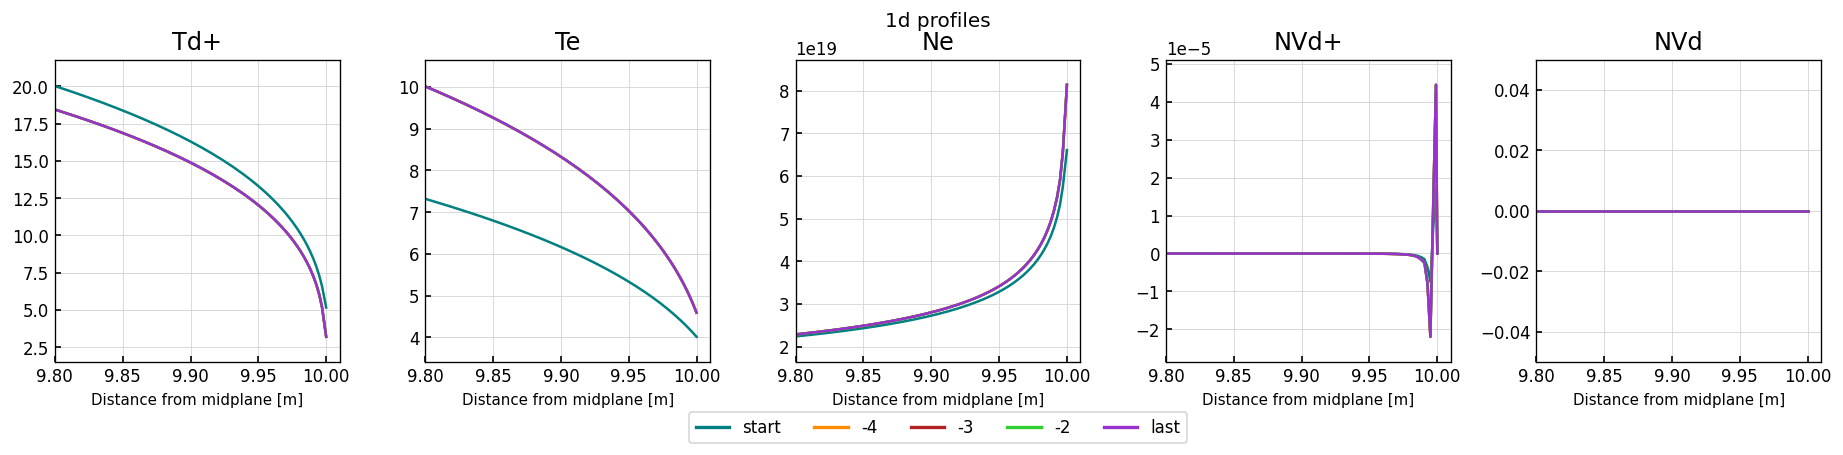

In [3]:
case = "add_qei"

lineplot(
    {
        "start":cs[case].ds.isel(t=0),
        "-4":cs[case].ds.isel(t=-4),
        "-3":cs[case].ds.isel(t=-3),
        "-2":cs[case].ds.isel(t=-2),
        "last":cs[case].ds.isel(t=-1),

    },
    clean_guards = False,
    guard_replace = True,
    params = ["Td+", "Te", "Ne", "NVd+", "NVd"],
    regions = ["1d"],
    lw = 1.5,
    markersize = 0,
    # xlims = (29.5, 30.02)
    xlims=(9.8,10.01)
)

# Full flux balance

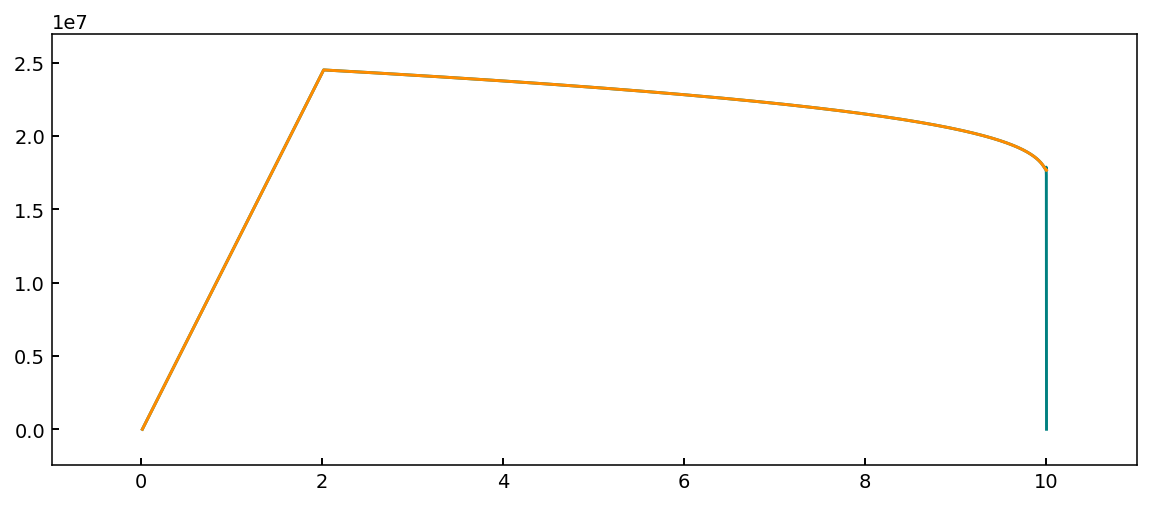

In [15]:
fig, ax = plt.subplots(figsize = (10, 4))

species = "d+"

ds = cs["add_qei"].ds
dom = ds.isel(pos = slice(2,-1))
ax.plot(dom["pos"], dom[f"ef{species}_cond_ylow"], label = "Conduction")
ax.plot(dom["pos"], dom[f"ef{species}_tot_ylow"], label = "Total")


# Check against old cases

## Base

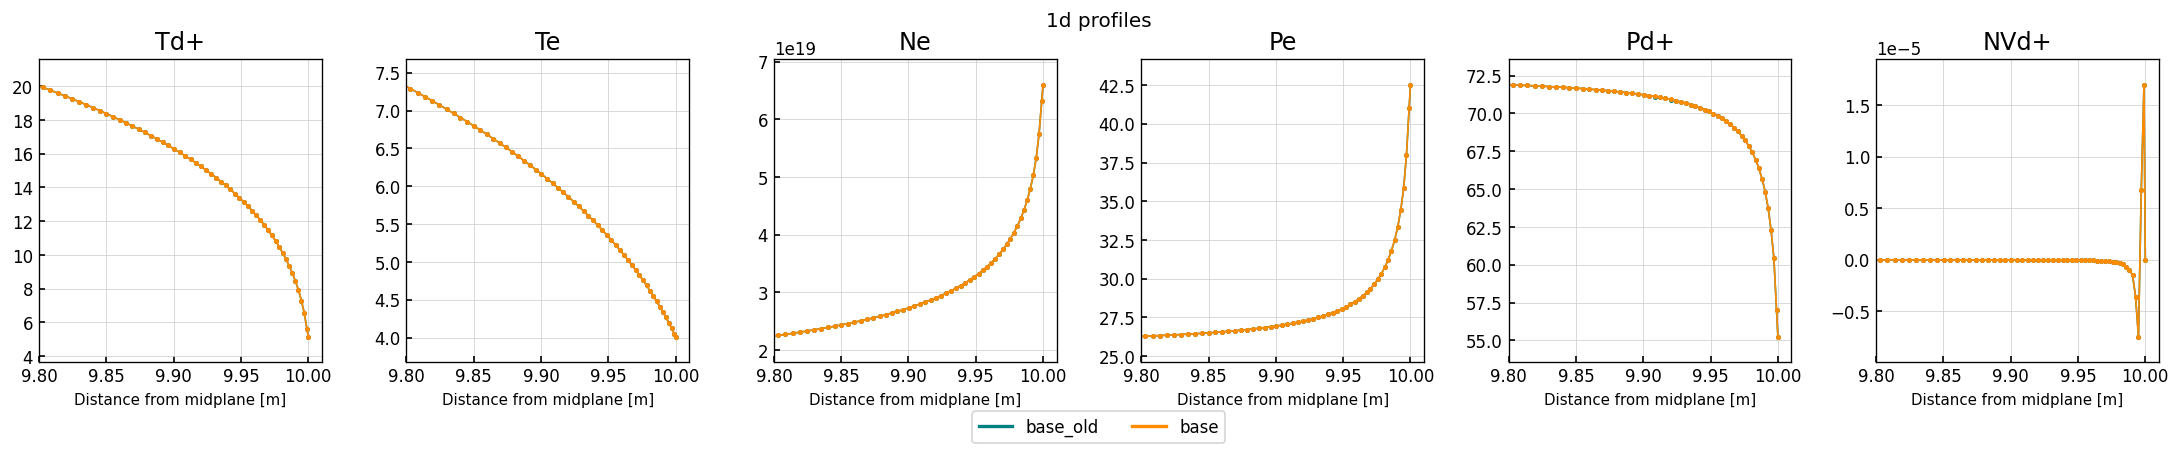

In [4]:
toplot = {
    "base_old" : cs["old_base"].ds.isel(t=-1),
    "base" : cs["base"].ds.isel(t=-1),
}

lineplot(
    toplot,
    clean_guards = False,
    guard_replace = True,
    logscale = False,
    params = ["Td+", "Te", "Ne", "Pe", "Pd+", "NVd+"],
    # params = ["Vd+"],
    regions = ["1d"],
    lw = 1,
    xlims=(9.8,10.01)
    # xlims = (9.98,10.005),
    # xlims = (29.6, 30.05)
    # xlims=(-0.1,1.5)
)

## Qei

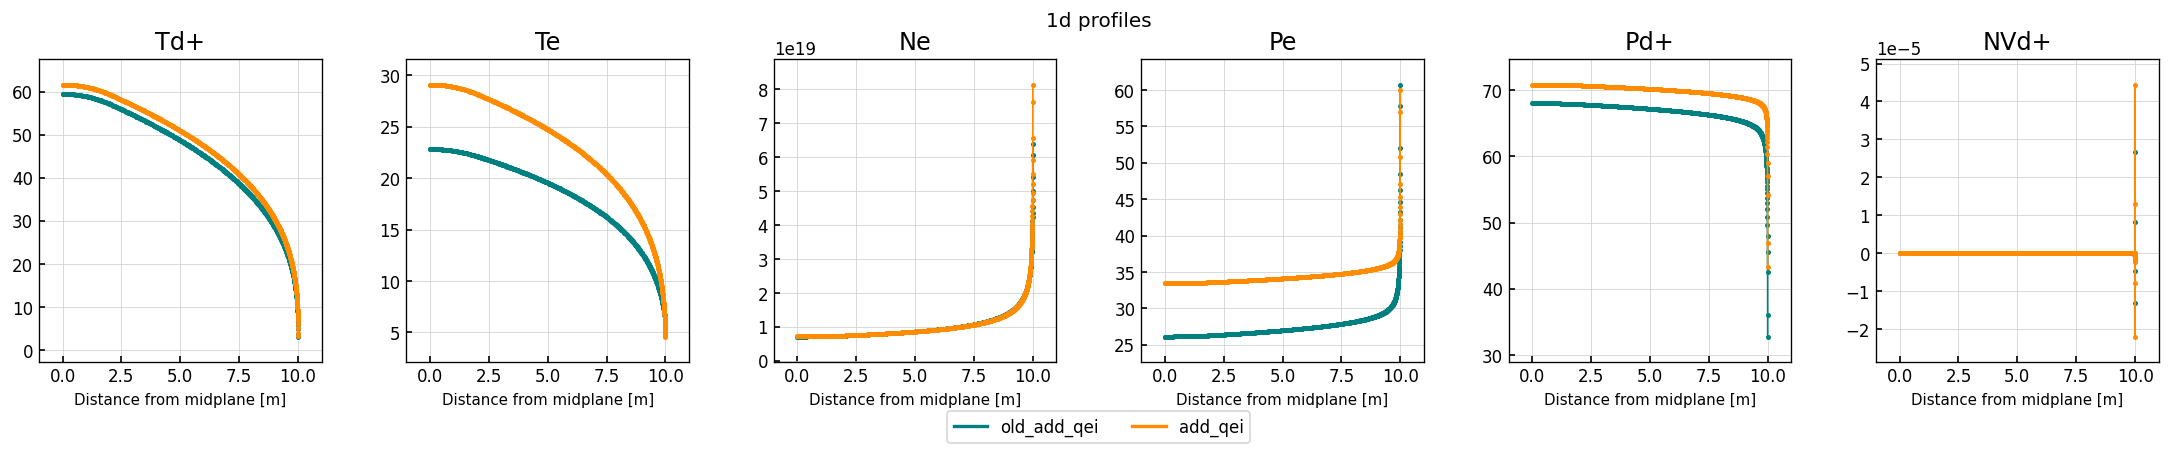

In [18]:
toplot = {
    # "base_old" : cs["old_base"].ds.isel(t=-1),
    # "base" : cs["base"].ds.isel(t=-1),
    "old_add_qei" : cs["old_add_qei"].ds.isel(t=-1),
    "add_qei" : cs["add_qei"].ds.isel(t=-1),
}

lineplot(
    toplot,
    clean_guards = False,
    guard_replace = True,
    logscale = False,
    params = ["Td+", "Te", "Ne", "Pe", "Pd+", "NVd+"],
    # params = ["Vd+"],
    regions = ["1d"],
    lw = 1,
    # xlims=(9.8,10.01)
    # xlims = (9.98,10.005),
    # xlims = (29.6, 30.05)
    # xlims=(-0.1,1.5)
)

In [4]:
cases = dict(
    qei = cs["add_qei"].ds.isel(t=-1, pos = slice(2,-2)),
    old_qei = cs["old_add_qei"].ds.isel(t=-1, pos = slice(2,-2))
)

for name, ds in cases.items():
    print(name)
    print("Ion heat: ", (ds["Pd+_src"]*ds["dv"]).values.sum())
    print("Electron heat: ", (ds["Pe_src"]*ds["dv"]).values.sum())

qei
Ion heat:  16786064.140434835
Electron heat:  16786064.140434835
old_qei
Ion heat:  16786064.140434835
Electron heat:  16786064.140434835


In [4]:
ds = cs["old_add_qei"].ds.isel(t=-1)
# ds = cs["add_qei"].ds.isel(t=-1)
bal = Balance1D(ds, verbose = False)
bal.get_terms()
bal.get_tallies()
bal.print_balances()

# power_in_e = bal.hbal["Ee_src"]
# power_in_i = bal.hbal["Ed+_src"]
# power_in = power_in_e + power_in_i
# sheath_power_e = ds["efe_tot_ylow"].isel(pos = -2).values * 1e-6
# sheath_power_i = ds["efd+_tot_ylow"].isel(pos = -2).values * 1e-6
# sheath_power = sheath_power_e + sheath_power_i

# print(f"Power in (electrons): {power_in_e:.2f} MW")
# print(f"Power in (ions): {power_in_i:.2f} MW")
# print(f"Total power in: {power_in:.2f} MW")

# print("")

# print(f"Sheath power (electrons): {sheath_power_e:.2f} MW")
# print(f"Sheath power (ions): {sheath_power_i:.2f} MW")
# print(f"Total sheath power: {sheath_power:.2f} MW")


Particle flows [s^-1]
----------------------
Sd+_src: 0.000e+00
Sd_src: 0.000e+00
Sd+_feedback: 0.000e+00
Sd+_iz: 0.000e+00
Sd+_rec: 0.000e+00
Sd_target_recycle: 0.000e+00
Sd+_sheath: 0.000e+00
----------------------
Derived quantities
----------------------
sources_sum: 0.000e+00
sheath_sum: 0.000e+00
recycle_frac: nan
----------------------
Diagnostic output
----------------------
(sources + recycled flow) / sources: nan


Heat flows [MW]
----------------------
Ed+_src: 2.518e+01
Ee_src: 2.518e+01
Pd_src: 0.000e+00
Rd+_ex: 0.000e+00
Rd+_rec: 0.000e+00
RAr: 0.000e+00
Ed_target_recycle: 0.000e+00
Ee_sheath: 3.576e+01
Ed+_sheath: 1.460e+01
----------------------
Derived quantities
----------------------
sources_sum: 5.036e+01
R_hydr_sum: 0.000e+00
R_imp_sum: 0.000e+00
R_sum: 0.000e+00
R_and_sources_sum: 5.036e+01
sheath_sum: 5.036e+01
power_in: 5.036e+01
power_out: 5.036e+01
----------------------
Diagnostic output
----------------------
Error: (R + Src - Sheath) / Src: -0.00%


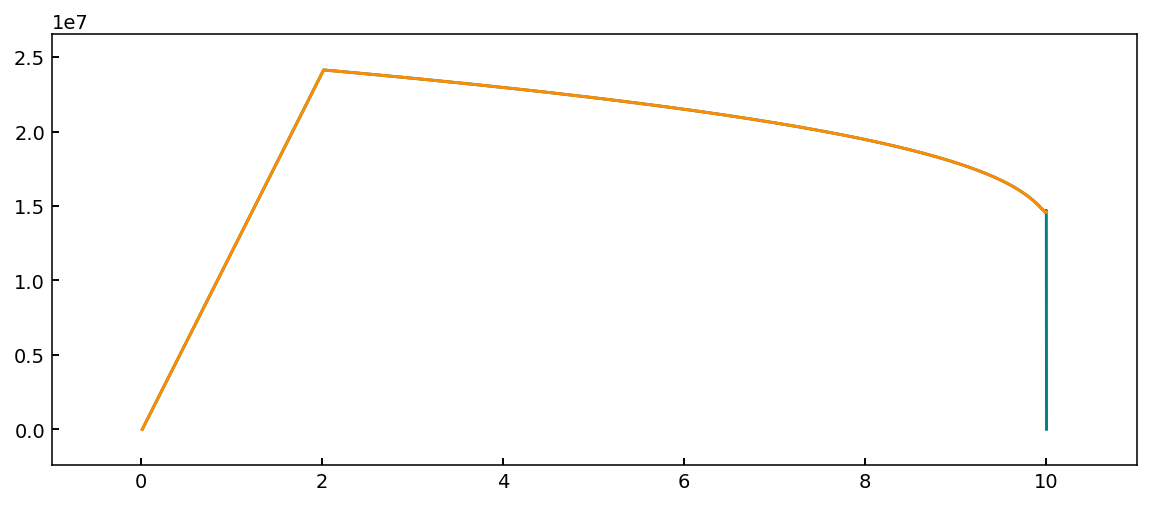

In [7]:
[print(x) for x in dom.data_vars if "efe" in x]

efe_cond_ylow
efe_kin_ylow
efe_tot_ylow


[None, None, None]

In [ ]:

# bal.print_balances()

power_in_e = bal.hbal["Ee_src"]
power_in_i = bal.hbal["Ed+_src"]

# power_out_e = bal.

print(f"Power in (electrons): {power_in_e:.2f} MW")
print(f"Power in (ions): {power_in_i:.2f} MW")
bal.hbal



Power in (electrons): 25.18 MW
Power in (ions): 25.18 MW


{'Ed+_src': np.float64(25.179096210652254),
 'Ee_src': np.float64(25.179096210652254),
 'Pd_src': array(0.),
 'Rd+_ex': array(0.),
 'Rd+_rec': array(0.),
 'RAr': array(0.),
 'Ed_target_recycle': array(0.),
 'Ee_sheath': np.float64(-0.0),
 'Ed+_sheath': np.float64(-0.0)}

In [55]:
bal.print_sheath_conditions()

dasheath = 6.28319
nesheath = 8.13538e+19
nisheath = 8.13538e+19
tesheath = 4.59338
tisheath = 3.19228
cssheath = 19310.3
vesheath = 0.0
visheath = 0.0


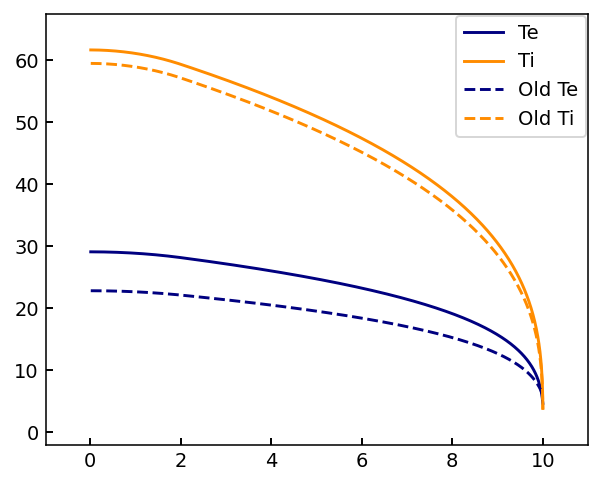

In [16]:
fig, ax = plt.subplots()

base = cs["base"].ds.isel(t=-1, pos = slice(2,-2))
old_base = cs["old_base"].ds.isel(t=-1, pos = slice(2,-2))
qei = cs["add_qei"].ds.isel(t=-1, pos = slice(2,-2))
old_qei = cs["old_add_qei"].ds.isel(t=-1, pos = slice(2,-2))

# ax.plot(base["pos"], base["Te"], c = "navy")
# ax.plot(base["pos"], base["Td+"], c = "darkorange")
# ax.plot(old_base["pos"], old_base["Te"],ls = "--", c = "navy")
# ax.plot(old_base["pos"], old_base["Td+"],ls = "--", c = "darkorange")

ax.plot(qei["pos"], qei["Te"], c = "navy", label = "Te")
ax.plot(qei["pos"], qei["Td+"], c = "darkorange", label = "Ti")
ax.plot(old_qei["pos"], old_qei["Te"],ls = "--", c = "navy", label = "Old Te")
ax.plot(old_qei["pos"], old_qei["Td+"],ls = "--", c = "darkorange", label = "Old Ti")
ax.legend()

Text(0.5, 0, 'Spar')

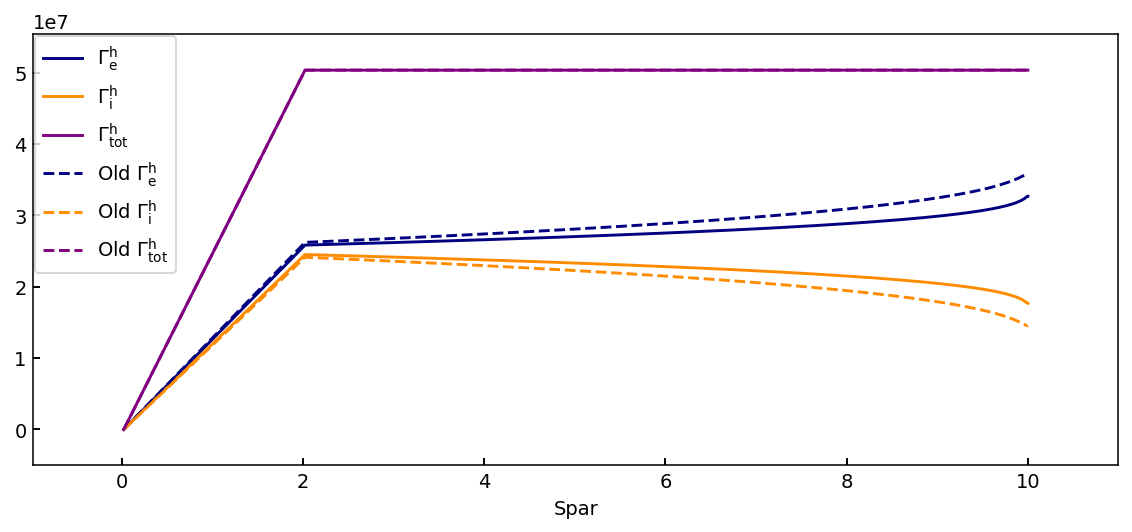

In [23]:
fig, ax = plt.subplots(figsize = (10, 4))

base = cs["base"].ds.isel(t=-1, pos = slice(2,-1))
old_base = cs["old_base"].ds.isel(t=-1, pos = slice(2,-1))
qei = cs["add_qei"].ds.isel(t=-1, pos = slice(2,-1))
old_qei = cs["old_add_qei"].ds.isel(t=-1, pos = slice(2,-1))

ax.plot(qei["pos"], qei["efe_tot_ylow"], c = "navy", label = r"$\Gamma^h_e$")
ax.plot(qei["pos"], qei["efd+_tot_ylow"], c = "darkorange", label = r"$\Gamma^h_i$")
ax.plot(qei["pos"], qei["efe_tot_ylow"]+qei["efd+_tot_ylow"], c = "purple", label = r"$\Gamma^h_{tot}$")

ax.plot(old_qei["pos"], old_qei["efe_tot_ylow"],ls = "--", c = "navy", label = r"Old $\Gamma^h_e$")
ax.plot(old_qei["pos"], old_qei["efd+_tot_ylow"],ls = "--", c = "darkorange", label = r"Old $\Gamma^h_i$")
ax.plot(old_qei["pos"], old_qei["efe_tot_ylow"]+old_qei["efd+_tot_ylow"], ls = "--", c = "purple", label = r"Old $\Gamma^h_{tot}$")
ax.legend()
ax.set_xlabel("Spar")

In [21]:
power_e = old_qei["efe_tot_ylow"].isel(pos=-1).values
power_i = old_qei["efd+_tot_ylow"].isel(pos=-1).values

(power_e+ power_i)*1e-6

np.float64(50.35844969909482)

In [22]:
power_e = qei["efe_tot_ylow"].isel(pos=-1).values
power_i = qei["efd+_tot_ylow"].isel(pos=-1).values

(power_e+ power_i)*1e-6

np.float64(50.35856919443766)

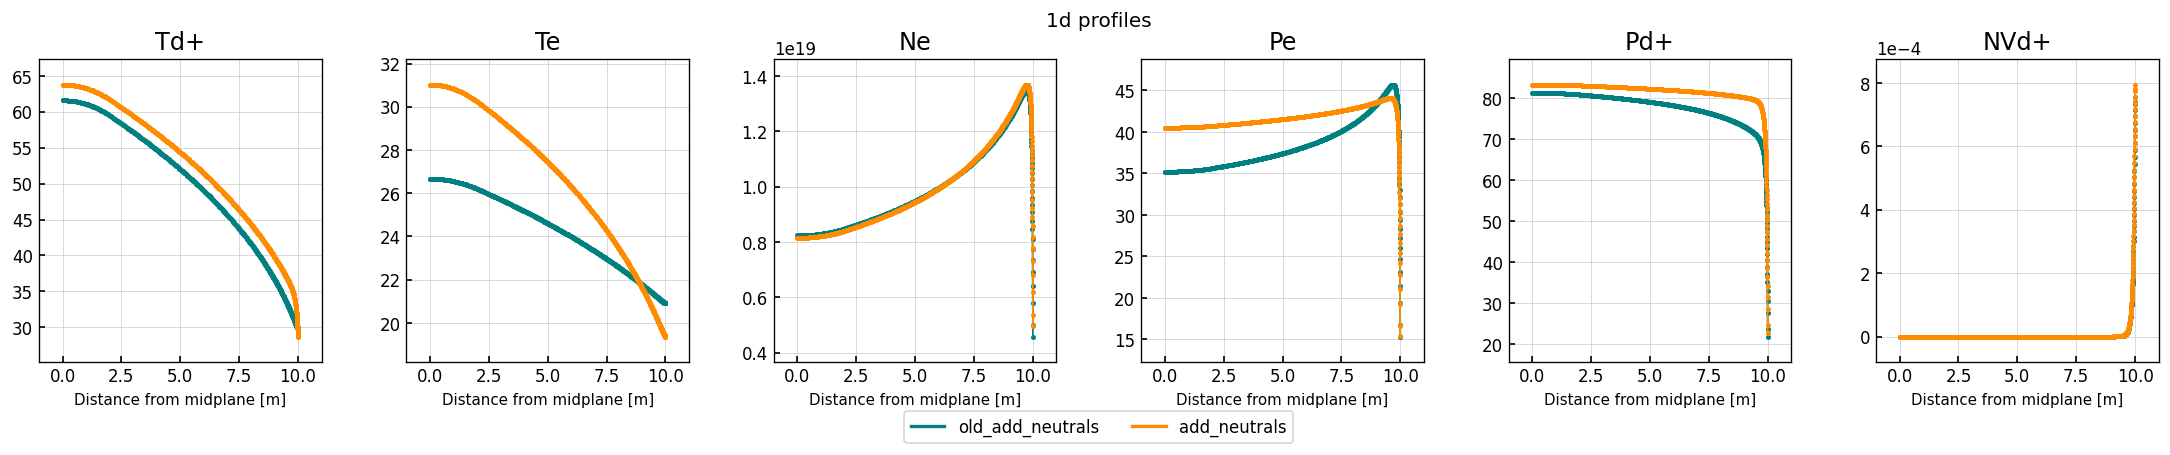

In [6]:
toplot = {
    "old_add_neutrals" : cs["old_add_neutrals"].ds.isel(t=-1),
    "add_neutrals" : cs["add_neutrals"].ds.isel(t=-1),
}

lineplot(
    toplot,
    clean_guards = False,
    guard_replace = True,
    logscale = False,
    params = ["Td+", "Te", "Ne", "Pe", "Pd+", "NVd+"],
    # params = ["Vd+"],
    regions = ["1d"],
    lw = 1,
    # xlims=(9.8,10.01)
    # xlims = (9.98,10.005),
    # xlims = (29.6, 30.05)
    # xlims=(-0.1,1.5)
)